In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

2023-07-08 01:00:11.927807: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 01:00:12.081217: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64/:/share/apps/python/miniconda3.9/lib
2023-07-08 01:00:12.081249: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-08 01:00:14.040295: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.

In [2]:
tf.__version__

'2.11.0'

In [3]:
df = pd.read_csv("../../../../../../data/ISDProcessed/2018/wona_temp.csv", index_col=[0])
data = df.values.astype("float32")

In [4]:
def get_indexer(
        n_rows, 
        window_size, 
        shift_size, 
        start_point, 
        leave_last
    ):
    return np.arange(window_size)[None, :] + start_point + shift_size*np.arange(((n_rows - window_size - leave_last - start_point) // shift_size) + 1)[:, None]

In [5]:
x_indexer = get_indexer(data.shape[0], 60, 1, 0, 30)
y_indexer = get_indexer(data.shape[0], 30, 1, 60, 0)

In [6]:
norm = tf.keras.layers.Normalization()
norm.adapt(data)

denorm = tf.keras.layers.Normalization(invert=True)
denorm.adapt(data)

2023-07-08 01:00:17.687653: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64/:/share/apps/python/miniconda3.9/lib
2023-07-08 01:00:17.687692: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-08 01:00:17.687721: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (deception01.pnl.gov): /proc/driver/nvidia/version does not exist
2023-07-08 01:00:17.688050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
norm_data = norm(data).numpy()
norm_data

array([[-2.2749598 , -2.0129623 , -2.7161915 , ..., -2.2888901 ,
        -2.1037984 , -1.6375939 ],
       [-2.2749598 , -2.0129623 , -2.6973066 , ..., -2.310769  ,
        -2.1346464 , -1.6375939 ],
       [-2.3305948 , -2.063324  , -2.6973066 , ..., -2.3632782 ,
        -2.1860602 , -1.723573  ],
       ...,
       [-0.6120875 ,  0.06193393, -1.5188951 , ..., -0.46419543,
        -0.2220609 ,  0.5118836 ],
       [-0.60126954,  0.08711471, -1.5642186 , ..., -0.5167046 ,
        -0.19121273,  0.33992532],
       [-0.5780882 ,  0.11229549, -1.6170962 , ..., -0.5604623 ,
        -0.10895097,  0.26827607]], dtype=float32)

In [8]:
inp_data = norm_data[x_indexer]
out_data = norm_data[y_indexer]
tf_data = tf.data.Dataset.from_tensor_slices((inp_data, out_data))

In [9]:
tf_data = tf_data.batch(64)

In [10]:
def get_model(model_name="lstm_"):
    if model_name == "lstm_":
        inputs = tf.keras.Input(shape=(60, data.shape[1]))
        x = tf.keras.layers.LSTM(64)(inputs)
        x = tf.keras.layers.RepeatVector(30)(x)
        output = tf.keras.layers.TimeDistributed(
                tf.keras.layers.Dense(data.shape[1])
            )(x)
    elif model_name == "lstm_wnorm":
        inputs = tf.keras.Input(shape=(60, data.shape[1]))
        x = tf.keras.layers.BatchNormalization()(inputs)
        x = tf.keras.layers.LSTM(64)(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.RepeatVector(30)(x)
        output = tf.keras.layers.TimeDistributed(
                tf.keras.layers.Dense(data.shape[1])
            )(x)
    elif model_name == "lstm_dense":
        inputs = tf.keras.Input(shape=(60, data.shape[1]))
        x = tf.keras.layers.LSTM(64)(inputs)
        x = tf.keras.layers.Dense(30*data.shape[1])(x)
        output = tf.keras.layers.Reshape((30, data.shape[1]))(x)
    elif model_name == "lstm_dense_wnorm":
        inputs = tf.keras.Input(shape=(60, data.shape[1]))
        x = tf.keras.layers.LSTM(64)(inputs)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dense(30*data.shape[1])(x)
        output = tf.keras.layers.Reshape((30, data.shape[1]))(x)
    elif model_name == "lstm2_dense":
        inputs = tf.keras.Input(shape=(60, data.shape[1]))
        x = tf.keras.layers.LSTM(64, return_sequences=True)(inputs)
        x = tf.keras.layers.LSTM(32)(x)
        x = tf.keras.layers.Dense(30*data.shape[1])(x)
        output = tf.keras.layers.Reshape((30, data.shape[1]))(x)
    elif model_name == "bilstm_dense":
        inputs = tf.keras.Input(shape=(60, data.shape[1]))
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(inputs)
        x = tf.keras.layers.Dense(30*data.shape[1])(x)
        output = tf.keras.layers.Reshape((30, data.shape[1]))(x)
    elif model_name == "bilstm128_dense":
        inputs = tf.keras.Input(shape=(60, data.shape[1]))
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(inputs)
        x = tf.keras.layers.Dense(30*data.shape[1])(x)
        output = tf.keras.layers.Reshape((30, data.shape[1]))(x)
    
    model = tf.keras.Model(inputs, output)
    return model

In [11]:
model=get_model("bilstm_dense") 
optimizer=tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=["mse", "mape", "mae"])
history = model.fit(tf_data, epochs=50)

Epoch 1/50
136/136 [==============================] - 12s 68ms/step - loss: 0.4482 - mse: 0.4482 - mape: 325.9180 - mae: 0.5139
Epoch 2/50
136/136 [==============================] - 9s 64ms/step - loss: 0.3204 - mse: 0.3204 - mape: 345.0469 - mae: 0.4398
Epoch 3/50
136/136 [==============================] - 9s 63ms/step - loss: 0.2738 - mse: 0.2738 - mape: 313.4369 - mae: 0.4026
Epoch 4/50
136/136 [==============================] - 9s 63ms/step - loss: 0.2410 - mse: 0.2410 - mape: 298.9063 - mae: 0.3741
Epoch 5/50
136/136 [==============================] - 9s 63ms/step - loss: 0.2174 - mse: 0.2174 - mape: 283.3985 - mae: 0.3553
Epoch 6/50
136/136 [==============================] - 9s 63ms/step - loss: 0.2072 - mse: 0.2072 - mape: 277.2119 - mae: 0.3479
Epoch 7/50
136/136 [==============================] - 9s 64ms/step - loss: 0.2040 - mse: 0.2040 - mape: 289.8370 - mae: 0.3470
Epoch 8/50
136/136 [==============================] - 9s 64ms/step - loss: 0.1905 - mse: 0.1905 - mape: 266.63

In [12]:
inp_data[:1]

array([[[-2.2749598, -2.0129623, -2.7161915, ..., -2.2888901,
         -2.1037984, -1.6375939],
        [-2.2749598, -2.0129623, -2.6973066, ..., -2.310769 ,
         -2.1346464, -1.6375939],
        [-2.3305948, -2.063324 , -2.6973066, ..., -2.3632782,
         -2.1860602, -1.723573 ],
        ...,
        [-2.5902255, -2.738169 , -1.7757286, ..., -1.9957138,
         -2.7053375, -2.7194977],
        [-2.5345905, -2.6878073, -1.8134981, ..., -1.9694593,
         -2.6487825, -2.8413012],
        [-2.5902255, -2.6273735, -1.8134981, ..., -2.0219684,
         -2.6487825, -2.9129503]]], dtype=float32)

In [13]:
pred = model(inp_data[:1], training=False)
pred

<tf.Tensor: shape=(1, 30, 163), dtype=float32, numpy=
array([[[-2.0815399, -2.2420492, -1.5424137, ..., -2.1103175,
         -2.0475392, -2.3918607],
        [-1.9962454, -2.1202047, -1.5239279, ..., -2.0449529,
         -1.9930624, -2.2704167],
        [-1.9042625, -1.9839537, -1.4637263, ..., -1.9761062,
         -1.9097935, -2.140746 ],
        ...,
        [-1.7662405, -1.9700372, -1.4337287, ..., -1.861609 ,
         -2.0172331, -1.9954967],
        [-1.6697295, -1.8319263, -1.3307906, ..., -1.7845056,
         -1.9421151, -1.8395153],
        [-1.5943766, -1.7322474, -1.2352515, ..., -1.7278129,
         -1.8721073, -1.7102859]]], dtype=float32)>

In [14]:
out_data[0]

array([[-2.6412244, -2.5719755, -1.8550447, ..., -2.0219684, -2.5922275,
        -2.9129503],
       [-2.3305948, -2.294987 , -1.9419147, ..., -1.9694593, -2.1346464,
        -2.95594  ],
       [-2.0709643, -2.1237578, -1.8588217, ..., -1.7769254, -1.6719241,
        -2.94161  ],
       ...,
       [-1.6629733, -1.8417331, -1.8588217, ..., -1.6281493, -2.1860602,
        -2.597694 ],
       [-1.6073382, -1.7913716, -1.7581027, ..., -1.6062704, -2.1860602,
        -2.3540864],
       [-1.551703 , -1.7309377, -1.6473118, ..., -1.5843916, -2.1860602,
        -2.1248088]], dtype=float32)

In [15]:
import matplotlib.pyplot as plt

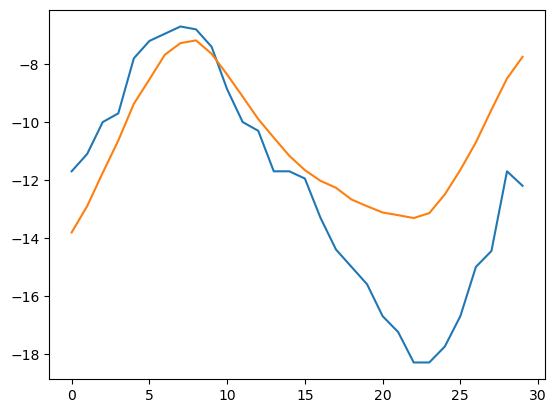

In [37]:
act_out = denorm(out_data[0])
pred_out = denorm(pred[0])

fig = plt.figure()
ax = fig.gca()

indx = 55
ax.plot(act_out[:, indx])
ax.plot(pred_out[:, indx])